In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
print(f'torch version: {torch.__version__}')

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch version: 1.13.0
using device: cuda


In [2]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
print(data.shape)
data.head()

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

raw_numpy= data.to_numpy()
np.random.shuffle(raw_numpy)
raw_torch = torch.tensor(raw_numpy)
X = raw_torch[:, 1:].type(torch.float)
y = raw_torch[:, 0].type(torch.long)
print(f"X.shape: {X.shape}, y.shape, {y.shape}")
train_split = int(0.8*len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(42000, 785)
X.shape: torch.Size([42000, 784]), y.shape, torch.Size([42000])
torch.Size([33600, 784]) torch.Size([8400, 784]) torch.Size([33600]) torch.Size([8400])


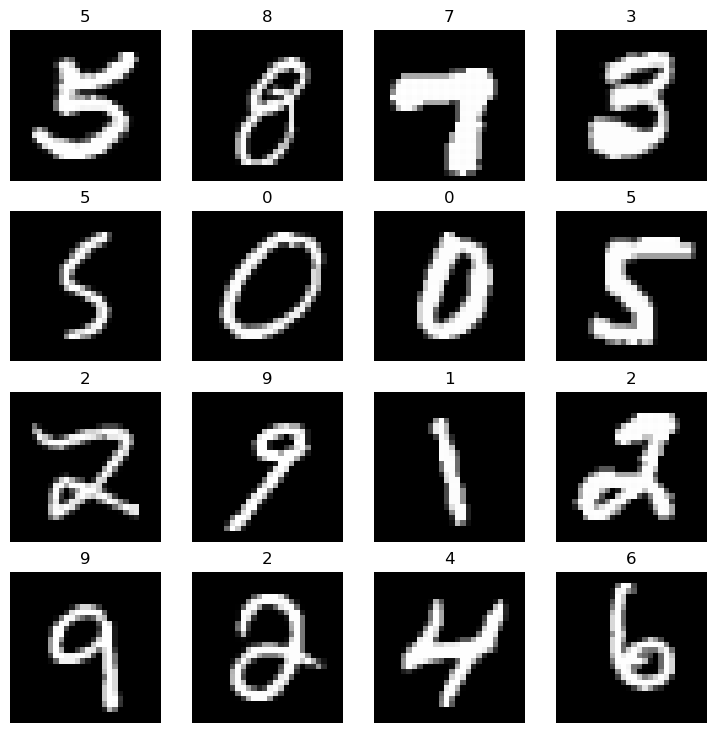

In [3]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(X_train), size = [1]).item()
    img  = X_train[random_idx].reshape((28, 28))
    label = y_train[random_idx].item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.cpu(), cmap = "gray")
    plt.title(label)
    plt.axis(False)

In [4]:
from torch.utils.data import Dataset, DataLoader
"""
Trigger warning :::
This is the worst implementation of a PyTorch Custom Dataset
you'll ever see lol
"""
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        return [data, label]
        sample = {"Data": data, "Class": label}
        return sample
    
    
### Hyperparameters
BATCH_SIZE = 2048

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)


train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle = True,
                              drop_last = True) #drop_last = True
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              drop_last = True) #drop_last = True

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

Length of train_dataloader: 16 batches of size 2048
Length of test_dataloader: 4 batches of size 2048
torch.Size([2048, 784]) torch.Size([2048])
torch.Size([2048, 784]) torch.Size([2048])


In [5]:
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

class AudoencoderTinyVGG(nn.Module):
    def __init__(self):
        super().__init__()
    
        bottleneck = 10
        colour_channels = 1
        hidden_units = 10
        
        
        block_1 = nn.Sequential(
            nn.Conv2d(in_channels=colour_channels,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        
        block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        
        block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        
        flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*9,
                      out_features=10))
        
        
        self.encoder = nn.Sequential(block_1, block_2, block_3, flatten)
        
        unflatten = nn.Sequential(
            nn.Linear(in_features=10,
                      out_features=hidden_units*16),
            nn.Unflatten(dim=1,
                         unflattened_size=(hidden_units, 4, 4)),
            nn.BatchNorm2d(hidden_units, affine=False))
        
        # Gives torch.Size([2048, 10, 6, 6]), but needs to be ..., 7, 7]
        # Have to change hidden_units to *16 (not *9)m and use kernel size
        # of 4 below to reshape [2048, 10, 8, 8] to  .. [2048, 10, 7, 7]
        block_d_1 = nn.Sequential(
            nn.Upsample(scale_factor=2,
                        mode='nearest'),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=4,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False))
        
        block_d_2 = nn.Sequential(
            nn.Upsample(scale_factor=2,
                        mode='nearest'),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False))
        
        block_d_3 = nn.Sequential(
            nn.Upsample(scale_factor=2,
                        mode='nearest'),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units, affine=False),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=colour_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1))
        
        flatten = nn.Flatten()
        
        self.decoder = nn.Sequential(unflatten, block_d_1, block_d_2, block_d_3, flatten)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_reshaped = x.view(-1, 1, 28, 28)
        return torch.clamp(self.decoder(self.encoder(x_reshaped)), max = 255)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"On device: {device}")

# Batch normalization
#Let us use B to denote a mini-batch of size m of the entire training set.
#The empirical mean and variance of B could thus be denoted as
#mu_B = 1/m sum(x_i), sigma_B = sum((x_i-m_B)^2)
#x_i := (x_i - mu_B)/sigma_B

#nn.ReLU(), nn.Sigmoid(), nn.BatchNormalization(), nn.Dropout(0.25),

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

class AudoencoderV3(nn.Module):
    def __init__(self):
        super().__init__()
        
        l1 = 128
        l2 = 64
        l3 = 32
        l4 = 16
        bottleneck = 10
        
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(num_features = 784, affine = False),
            nn.Linear(in_features=784,
                      out_features=l1),
            nn.BatchNorm1d(num_features = l1, affine = False),
            nn.Linear(in_features = l1,
                      out_features = l2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l2, affine = False),
            nn.Linear(in_features = l2,
                      out_features = l3),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l3, affine = False),
            nn.Linear(in_features = l3,
                      out_features = l4),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l4, affine = False),
            nn.Linear(in_features = l4,
                      out_features = bottleneck),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = bottleneck, affine = False)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features = bottleneck,
                      out_features = l4),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l4, affine = False),
            nn.Linear(in_features=l4,
                      out_features=l3),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l3, affine = False),
            nn.Linear(in_features=l3,
                      out_features=l2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l2, affine = False),
            nn.Linear(in_features = l2,
                      out_features = l1),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l1, affine = False),
            nn.Linear(in_features = l1,
                      out_features = 784),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.clamp(self.decoder(self.encoder(x)), max = 255)
#         return torch.mul(self.decoder(self.encoder(x)), 255)

# model_0 = AudoencoderV3().to(device)
model_0 = AudoencoderTinyVGG().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.1) #weight_decay = 1e-8
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
model_0

On device: cuda


AudoencoderTinyVGG(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [7]:
# every element in end array is 255.
# model_0.encoder(train_features_batch.view(-1, 1, 28, 28))[0]
# tensor([ 3.2985e+09,  3.3064e+09,  2.2986e+09, -3.2670e+09, -9.2574e+08,
#         -3.4244e+09, -3.2880e+09,  3.2631e+09,  3.3694e+09,  2.4712e+09],
#        device='cuda:0', grad_fn=<SelectBackward0>)
# After using BatchNorm2d, 
# tensor([-1.6874,  1.5085,  0.5234,  1.2144, -0.5199, -1.3996, -1.0329,  0.1077,
#          0.9449, -0.2703], device='cuda:0', grad_fn=<SelectBackward0>)

# model_0.encoder(train_features_batch.view(-1, 1, 28, 28))[0]
# model_0(train_features_batch)[0]

In [8]:
# After 250 epochs each
# ReLU(with clamp) at end of function gives loss:  1251.1305 (after 500 epochs: 1229.7341)
# Sigmoid(with x 255) ends on 2036.6487


# Using TinyVGG architecture
# Epoch: 90 | Train loss: 988.8109 | Test loss: 995.5472 | Learning rate: 0.05

In [9]:
from tqdm.auto import tqdm #progress bar
import time
t1 = time.time()
lrs = []

epochs = 100
for epoch in tqdm(range(epochs)):
    for batch, (X, _) in enumerate(train_dataloader):
        X=X.to(device)
        
        model_0.train()
        #1. Forward pass
        y_pred = model_0(X)
        #2 Calculate loss (per batch)
        loss = loss_fn(y_pred, X)
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
        
    model_0.eval()  
    if epoch % 10 == 0:
        train_loss = 0
        test_loss = 0

        with torch.inference_mode(): #context manager
            for X_t, _ in train_dataloader:
                X_t = X_t.to(device)
                y_t_pred = model_0(X_t)
                loss_t = loss_fn(y_t_pred, X_t)
                train_loss+=loss_t #accumulate train loss
            for X_test, _ in test_dataloader:
                X_test = X_test.to(device)
                y_test_pred = model_0(X_test)
                loss_test = loss_fn(y_test_pred, X_test)
                test_loss+=loss_test #accumulate train loss

            train_loss /= len(train_dataloader)
            test_loss /= len(test_dataloader)
        cur_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Learning rate: {cur_lr}")
            
print(f'Taken {float(time.time()-t1):.5f} seconds.')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 30643.4180 | Test loss: 30655.0117 | Learning rate: 0.1
Epoch: 10 | Train loss: 1841.9708 | Test loss: 1827.5945 | Learning rate: 0.1
Epoch: 20 | Train loss: 1317.4633 | Test loss: 1308.2719 | Learning rate: 0.1
Epoch: 30 | Train loss: 1135.5658 | Test loss: 1133.2001 | Learning rate: 0.1
Epoch: 40 | Train loss: 1189.3984 | Test loss: 1189.1377 | Learning rate: 0.1
Epoch: 50 | Train loss: 1076.6074 | Test loss: 1079.6121 | Learning rate: 0.05
Epoch: 60 | Train loss: 994.1753 | Test loss: 997.9559 | Learning rate: 0.05
Epoch: 70 | Train loss: 977.4285 | Test loss: 983.9146 | Learning rate: 0.05
Epoch: 80 | Train loss: 1005.2458 | Test loss: 1010.9742 | Learning rate: 0.05
Epoch: 90 | Train loss: 982.5375 | Test loss: 988.5124 | Learning rate: 0.05
Taken 196.68180 seconds.


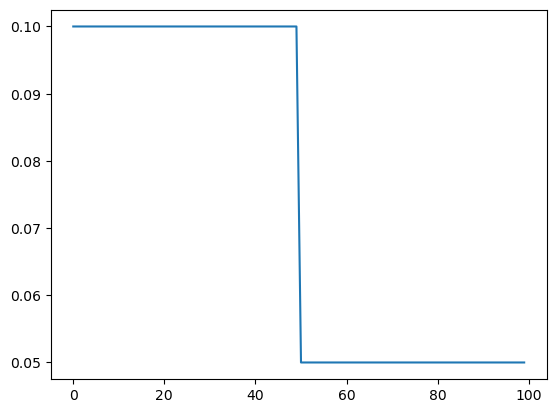

In [10]:
plt.plot(lrs)

In [12]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
print(data.shape)
data.head()

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

raw_numpy= data.to_numpy()
np.random.shuffle(raw_numpy)
raw_torch = torch.tensor(raw_numpy)
X = raw_torch[:, 1:].type(torch.float)
y = raw_torch[:, 0].type(torch.long)
print(f"X.shape: {X.shape}, y.shape, {y.shape}")
train_split = int(0.8*len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(42000, 785)
X.shape: torch.Size([42000, 784]), y.shape, torch.Size([42000])
torch.Size([33600, 784]) torch.Size([8400, 784]) torch.Size([33600]) torch.Size([8400])


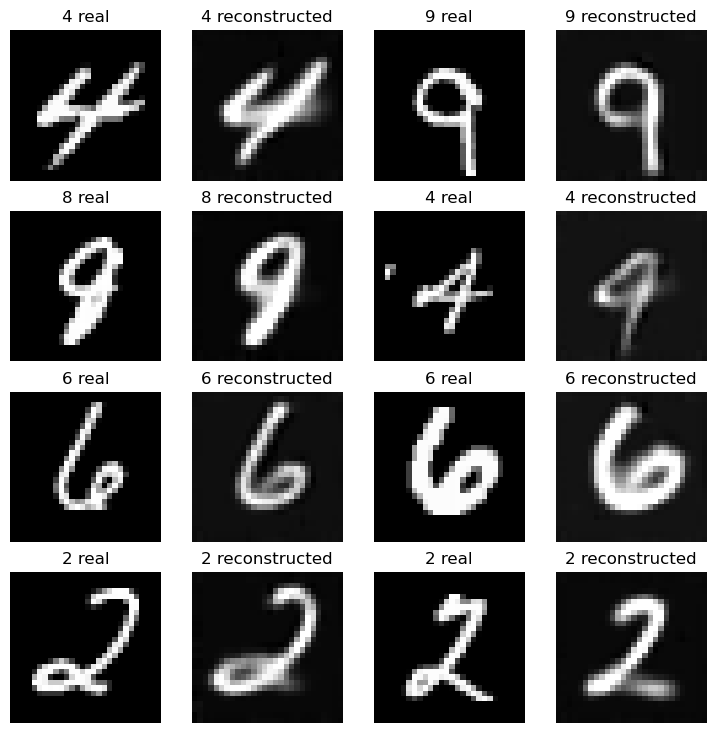

In [13]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
X=X.to(device)
model_0.eval()
with torch.inference_mode():
    all_pred = model_0(X)
for i in range(1, rows*cols+1, 2):
    cur = X[i]
    pred = all_pred[i]
    img_real = cur.reshape((28, 28))
    img_pred = pred.reshape((28, 28))
    label = y[i].item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img_real.cpu().detach().numpy(), cmap = "gray")
    plt.title(str(label) +" real")
    plt.axis(False)
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img_pred.cpu().detach().numpy(), cmap = "gray")
    plt.title(str(label) + " reconstructed")
    plt.axis(False)

In [15]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "autoencoder_model_vgg.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/autoencoder_model_vgg.pth


In [16]:
stop

NameError: name 'stop' is not defined

In [50]:
class SuffixNN(nn.Module):
    def __init__(self, encoder: nn.Module):
        super().__init__()
        
        for param in encoder.parameters(): # Freezing encodoer weights
            param.requires_grad = False
            
        #-> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
        l1 = 50
        
        
        suffix = nn.Sequential(
        nn.BatchNorm1d(num_features = 10, affine = False),
        nn.Linear(in_features=10,
                  out_features=l1),
        nn.BatchNorm1d(num_features = l1, affine = False),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features = l1,
              out_features = 10))
        
        self.network = nn.Sequential(encoder, suffix)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_reshaped = x.view(-1, 1, 28, 28)
        return self.network(x_reshaped)


# load autoencoder
# autoencoder = AudoencoderV3()
autoencoder = AudoencoderTinyVGG()
autoencoder.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
autoencoder = autoencoder.to(device)

# create suffix model
    
model = SuffixNN(encoder=autoencoder.encoder).to(device)
print(f'model parameters are on device: {next(model.parameters()).device}')
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.1) #weight_decay = 1e-8
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

model

model parameters are on device: cuda:0


SuffixNN(
  (network): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (6): MaxPool2d(kernel_s

In [ ]:
from torch.utils.data import Dataset, DataLoader
"""
Trigger warning :::
This is the worst implementation of a PyTorch Custom Dataset
you'll ever see lol
"""
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        return [data, label]
        sample = {"Data": data, "Class": label}
        return sample
    
    
### Hyperparameters
BATCH_SIZE = 2048

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)


train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle = True,
                              drop_last = True) #drop_last = True
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              drop_last = True) #drop_last = True

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

In [51]:
from tqdm.auto import tqdm #progress bar
import time
t1 = time.time()
lrs = []

train_loss_graph = []
test_loss_graph = []

epochs = 10
for epoch in tqdm(range(epochs)):
    for batch, (X, y) in enumerate(train_dataloader):
        X=X.to(device)
        model.train()
        #1. Forward pass
        y_pred = model(X)
        #2 Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        model_0.eval()  
        train_loss = 0
        test_loss = 0
        
        if batch % 5 == 0:
            with torch.inference_mode(): #context manager
                for X_t, y_t in train_dataloader:
                    X_t = X_t.to(device)
                    y_t_logits = model(X_t)
                    loss_t = loss_fn(y_t_logits, y_t)
                    train_loss+=loss_t #accumulate train loss
                    train_pred_labels = torch.argmax(y_t_logits, dim=1)
                    train_acc = accuracy_fn(y_true = y_t,
                                            y_pred = train_pred_labels)

                for X_test, y_test in test_dataloader:
                    X_test = X_test.to(device)
                    y_test_logits = model(X_test)
                    loss_test = loss_fn(y_test_logits, y_test)
                    test_loss+=loss_test #accumulate train loss
                    test_pred_labels = torch.argmax(y_test_logits, dim=1)
                    test_acc = accuracy_fn(y_true = y_test,
                                            y_pred = test_pred_labels)

                train_loss /= len(train_dataloader)
                test_loss /= len(test_dataloader)

                cur_lr = optimizer.param_groups[0]["lr"]
                print(f"E:{epoch}, b:{batch} |Train loss: {train_loss:.4f}, acc:{train_acc:.4f} | Test loss: {test_loss:.4f}, acc: {test_acc:.4f} | lr: {cur_lr}")
                train_loss_graph.append(train_loss.cpu().detach().numpy())
                test_loss_graph.append(test_loss.cpu().detach().numpy())
            
print(f'Taken {float(time.time()-t1):.5f} seconds.')

  0%|          | 0/10 [00:00<?, ?it/s]

E:0, b:0 |Train loss: 1.1149, acc:71.9238 | Test loss: 1.1149, acc: 73.2422 | lr: 0.1
E:0, b:5 |Train loss: 0.3797, acc:87.1094 | Test loss: 0.3926, acc: 87.3535 | lr: 0.1
E:0, b:10 |Train loss: 0.3319, acc:90.8203 | Test loss: 0.3477, acc: 89.1602 | lr: 0.1
E:0, b:15 |Train loss: 0.3034, acc:90.4297 | Test loss: 0.3197, acc: 89.5020 | lr: 0.1
E:1, b:0 |Train loss: 0.3086, acc:90.7715 | Test loss: 0.3195, acc: 89.2090 | lr: 0.1
E:1, b:5 |Train loss: 0.2959, acc:90.5762 | Test loss: 0.2956, acc: 89.7461 | lr: 0.1
E:1, b:10 |Train loss: 0.2813, acc:91.3574 | Test loss: 0.2827, acc: 89.8926 | lr: 0.1
E:1, b:15 |Train loss: 0.2616, acc:91.6992 | Test loss: 0.2842, acc: 90.5273 | lr: 0.1
E:2, b:0 |Train loss: 0.2572, acc:91.6504 | Test loss: 0.2677, acc: 91.0645 | lr: 0.1
E:2, b:5 |Train loss: 0.2477, acc:92.3828 | Test loss: 0.2656, acc: 91.3086 | lr: 0.1
E:2, b:10 |Train loss: 0.2437, acc:92.0898 | Test loss: 0.2522, acc: 91.3574 | lr: 0.1
E:2, b:15 |Train loss: 0.2357, acc:92.5781 | Test

In [ ]:
#---------For original (Dense) network------
#1000 total elements (Training on 7 batches of size 128)
#E:9, b:6 |Train loss: 0.3471, acc:89.0625 | Test loss: 0.4639, acc: 89.8438 | lr: 0.05

#500 total elements (Training on 7 batches of size 64)
#E:9, b:6 |Train loss: 0.3537, acc:89.0625 | Test loss: 0.6855, acc: 73.4375 | lr: 0.05
# Loss graph is very choppy, different between train and test loss/accuracy becomes larger over time (=> overfitting)

#E:19, b:3 |Train loss: 0.2972, acc:90.6250 | Test loss: 0.6904, acc: 79.6875 | lr: 0.05
#Model is definitely overfitting (caused by the smaller amount of available data)

#---------Tiny VGG inspired network------
# E:9, b:15 |Train loss: 0.2056, acc:92.7734 | Test loss: 0.2199, acc: 91.5527 | lr: 0.0125

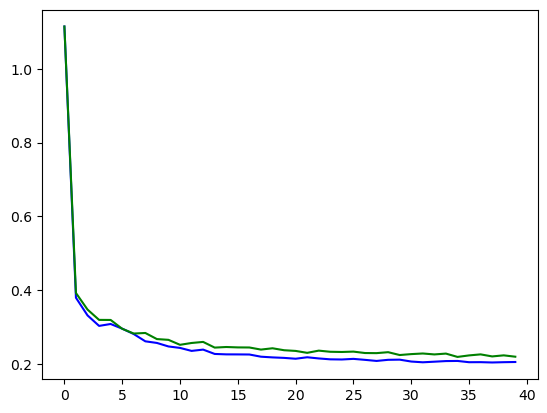

In [52]:
plt.plot(train_loss_graph, color = 'blue')
plt.plot(test_loss_graph, color = 'green')
plt.show()

In [ ]:
stop

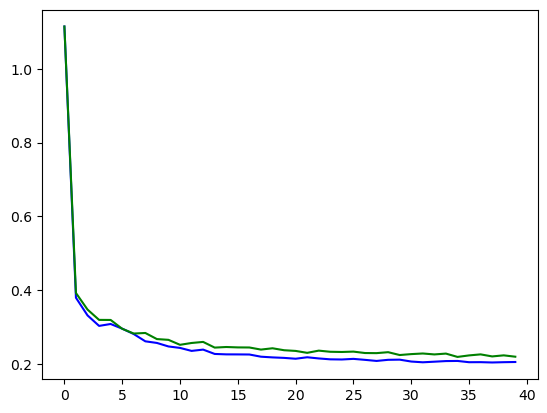

In [53]:
plt.plot(train_loss_graph, color = 'blue')
plt.plot(test_loss_graph, color = 'green')
plt.show()

In [60]:
#E:9, b:15 |Train loss: 0.3213, acc:90.1367 | Test loss: 0.3504, acc: 89.0137 | lr: 0.0125
#Using 1 hidden layer of 50 nodes


torch.Size([2048, 784]) torch.Size([2048])


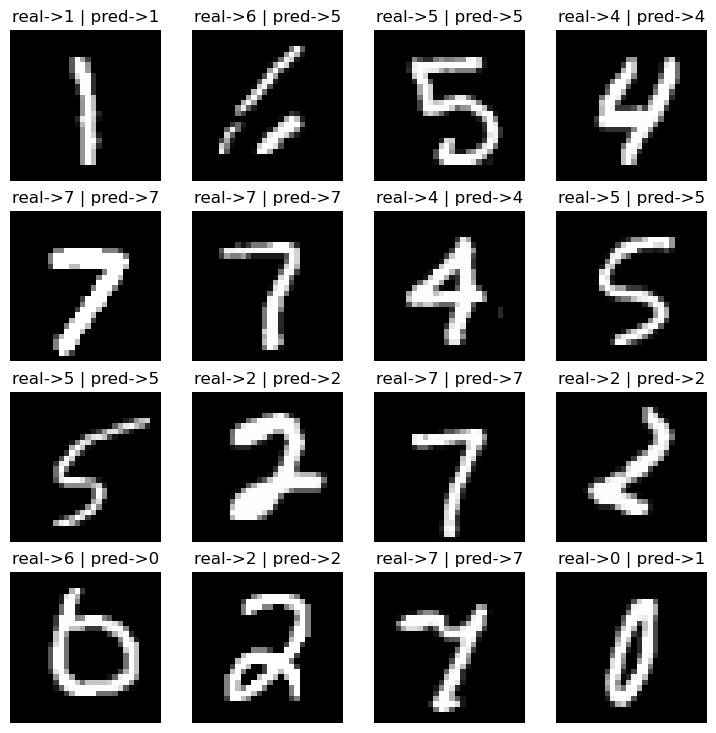

In [61]:
#Showing numbers with their predictions
model_0.eval()
with torch.inference_mode(): #context manager
    for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test_logits = model(X_test)
        test_pred_labels = torch.argmax(y_test_logits, dim=1)
        break
    print(X_test.shape, test_pred_labels.shape)
    
    fig = plt.figure(figsize=(9,9))
    rows, cols = 4, 4

    for i in range(1, rows*cols+1):
        fig.add_subplot(rows, cols, i)
        img_real = X_test[i].reshape((28, 28)).cpu().detach().numpy()
        plt.imshow(img_real, cmap = "gray")
        label = f"real->{y_test[i]} | pred->{test_pred_labels[i]}"
        plt.title(label)
        plt.axis(False)

torch.Size([2048, 784]) torch.Size([2048])


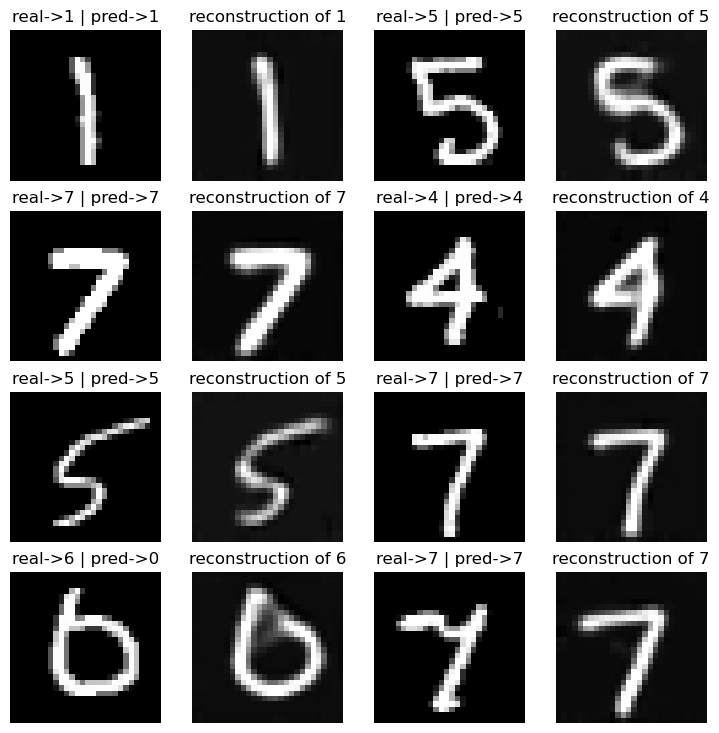

In [62]:
#Showing numbers with their predictions & reconstructions from the autoencoder
model_0.eval()
with torch.inference_mode(): #context manager
    for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test_logits = model(X_test)
        test_pred_labels = torch.argmax(y_test_logits, dim=1)
        break
    print(X_test.shape, test_pred_labels.shape)
    all_reconstructions = autoencoder(X_test)
    
    fig = plt.figure(figsize=(9,9))
    rows, cols = 4, 4
    offset = 0
    for i in range(1+offset, rows*cols+1+offset, 2):
        fig.add_subplot(rows, cols, i-offset)
        img_real = X_test[i].reshape((28, 28)).cpu().detach().numpy()
        plt.imshow(img_real, cmap = "gray")
        label = f"real->{y_test[i]} | pred->{test_pred_labels[i]}"
        plt.title(label)
        plt.axis(False)
        
        fig.add_subplot(rows, cols, i+1-offset)
        img_real = all_reconstructions[i].reshape((28, 28)).cpu().detach().numpy()
        plt.imshow(img_real, cmap = "gray")
        label = f"reconstruction of {y_test[i]}"
        plt.title(label)
        plt.axis(False)

torch.Size([2048, 784]) torch.Size([2048])


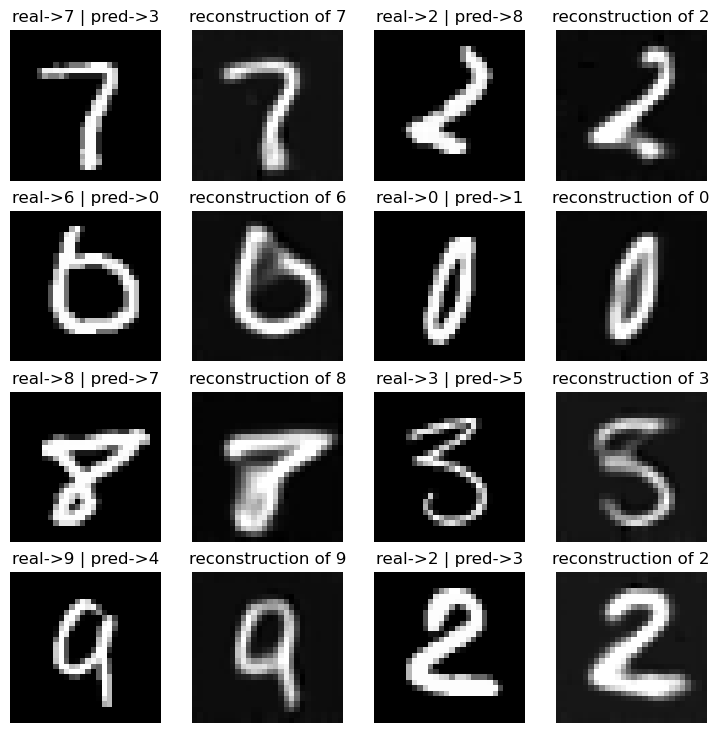

In [63]:
#Showing only incorrect examples
model_0.eval()
with torch.inference_mode(): #context manager
    for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test_logits = model(X_test)
        test_pred_labels = torch.argmax(y_test_logits, dim=1)
        break
    print(X_test.shape, test_pred_labels.shape)
    all_reconstructions = autoencoder(X_test)
    
    fig = plt.figure(figsize=(9,9))
    rows, cols = 4, 4
    j = 0 # index for X_test
    i = 1 # number of incorrect ones found
    while i < rows*cols+1:
        if y_test[j] != test_pred_labels[j]:
            fig.add_subplot(rows, cols, i)
            img_real = X_test[j].reshape((28, 28)).cpu().detach().numpy()
            plt.imshow(img_real, cmap = "gray")
            label = f"real->{y_test[j]} | pred->{test_pred_labels[j]}"
            plt.title(label)
            plt.axis(False)

            fig.add_subplot(rows, cols, i+1)
            img_real = all_reconstructions[j].reshape((28, 28)).cpu().detach().numpy()
            plt.imshow(img_real, cmap = "gray")
            label = f"reconstruction of {y_test[j]}"
            plt.title(label)
            plt.axis(False)
            i+=2
        j+=1

In [ ]:
#Checking parameters do not change during training for the encoder, i.e. the weights are actually frozen
list(model.encoder.parameters()) == list(autoencoder.encoder.parameters())
#:)))))

In [ ]:
list(autoencoder.encoder.parameters())[0]

In [ ]:
list(model.encoder.parameters())[0]